# IFN711 - Budget Analysis for Leap in!

## Install the dependencies stored in *requirments.txt*. 

In [146]:
!pip install -r requirements.txt

You should consider upgrading via the 'c:\users\ihand\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


## Import statements

In [147]:
import pandas as pd
import pymysql
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from apyori import apriori
# Imports for the neural network
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import LogisticRegression
#Imports for Clustering
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
# Load the .env file for database credentials
from dotenv import load_dotenv

## Sign into the Database using credentials either stored in .env file, or **manual input**.

In [148]:
# Declare variables
host = None
port = None
db = None
user = None
password = None
# Load the .env file to access database credentials
if load_dotenv():
    # Assign required values to variables
    host=os.getenv("host")
    port=int(os.getenv("port"))
    db=os.getenv("dbname")
    user=os.getenv("user")
    password=os.getenv("password")
    # Confirm loading of credentials
    print("Database Credentials Loaded Successfully.")
# If unable to load env file, take manual input.
else:
    # Confirm failure of loading of credentials
    print("Unable to detect Database Credentials. Please enter credentials manually.\n")
    # Request manual entry of credentials
    host = input("\nPlease enter host address: ")
    user = input("\nPlease enter username: ")
    password = input("\nPlease enter password: ")
    port = input("\nPlease enter port number: ")
    db = input("\nPlease enter database name: ")
    # Convert port to int
    port = int(port)
####### Connection to Client Database #######
conn = pymysql.connect(host=host, user=user, port=port, password=password, db=db)
# Print connection confirmation
print(conn)

Database Credentials Loaded Successfully.


## Make a dataframe of customer/user information.

In [149]:
df_user= pd.read_sql("select m.id as member_id, m.membership_number, m.status, m.price_zone_code, m.member_key, s.u_ndis_number, s.u_disabilities, s.u_gender, s.u_date_of_birth, r.SA1, r.SA2, r.SA3,r.SA4  from SNOW_csm_consumer_user s left join  HH_member m  on s.u_ndis_number = m.membership_number left join libe_leapinprod_memberregion r on r.MemberId = s.u_leapin_id where s.u_stage = 'li_managed' and s.u_ndis_number is not null;", con=conn)

# Display summary information of df_user          
df_user.info()
df_user.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6241 entries, 0 to 6240
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   member_id          6115 non-null   float64
 1   membership_number  6115 non-null   object 
 2   status             6115 non-null   object 
 3   price_zone_code    6115 non-null   object 
 4   member_key         6115 non-null   object 
 5   u_ndis_number      6241 non-null   object 
 6   u_disabilities     6241 non-null   object 
 7   u_gender           6241 non-null   object 
 8   u_date_of_birth    6239 non-null   object 
 9   SA1                6021 non-null   float64
 10  SA2                6021 non-null   float64
 11  SA3                6021 non-null   float64
 12  SA4                6021 non-null   float64
dtypes: float64(5), object(8)
memory usage: 634.0+ KB


,member_id,membership_number,status,price_zone_code,member_key,u_ndis_number,u_disabilities,u_gender,u_date_of_birth,SA1,SA2,SA3,SA4
0,1613.0,916644409,managed,ACT_NSW_QLD_VIC,d74bcd00-d205-11ea-b0d9-53acaecd0b82,916644409,,,1922-11-30,3100614.0,31006.0,30101.0,301.0
1,3132.0,262354568,managed,ACT_NSW_QLD_VIC,5d057910-dce6-11ea-812e-09cdf4382371,262354568,,,2007-04-06,1144614.0,11446.0,12303.0,123.0
2,1786.0,233367363,managed,ACT_NSW_QLD_VIC,222759f0-d212-11ea-8b42-db603b1b9020,233367363,,Female,1954-03-26,0.0,0.0,0.0,0.0
3,2562.0,981297214,managed,ACT_NSW_QLD_VIC,b0a9ca70-d50d-11ea-8224-836b70d82925,981297214,,Female,1978-12-24,3138504.0,31385.0,31401.0,314.0
4,1614.0,631304335,managed,ACT_NSW_QLD_VIC,d75087f0-d205-11ea-b0d9-53acaecd0b82,631304335,,,1995-08-18,2142119.0,21421.0,21701.0,217.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2792.0,266947556,managed,ACT_NSW_QLD_VIC,c2ce1270-d6d3-11ea-9cd1-f194648955a5,266947556,"Hypothyroidism , Fibromyalgia , Thyroid , Deaf",Female,1932-04-07,1158802.0,11588.0,12504.0,125.0
96,1964.0,723367568,managed,ACT_NSW_QLD_VIC,614c9420-d21b-11ea-b617-61a96cd5c136,723367568,,Male,1978-09-21,0.0,0.0,0.0,0.0
97,551.0,708296665,managed,ACT_NSW_QLD_VIC,c3e4aad0-c7e6-11ea-bd70-2bdba120f26c,708296665,,,2001-09-15,2110528.0,21105.0,20601.0,206.0
98,2079.0,331401992,managed,ACT_NSW_QLD_VIC,a80f41a0-d220-11ea-b70a-d17e589b1829,331401992,,Male,1940-04-30,3107107.0,31071.0,30304.0,303.0


## Make a dataframe of claims information.

In [150]:
df_claims= pd.read_sql("SELECT c.id as claim_id, c.invoice_id, c.state, c.risk_level, c.start_date FROM HH_claim c;", con=conn)

# Display summary information of df_user
df_claims.info()
df_claims.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968874 entries, 0 to 968873
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   claim_id    968874 non-null  int64 
 1   invoice_id  968874 non-null  int64 
 2   state       968874 non-null  object
 3   risk_level  968874 non-null  object
 4   start_date  968874 non-null  object
dtypes: int64(2), object(3)
memory usage: 37.0+ MB


,claim_id,invoice_id,state,risk_level,start_date
0,1,1,PAID,NO,2020-04-30
1,2,2,PAID,NO,2020-05-01
2,3,3,PAID,NO,2020-04-23
3,4,4,PAID,NO,2020-04-30
4,5,5,PAID,NO,2020-05-07
...,...,...,...,...,...
95,96,88,PAID,NO,2019-10-21
96,97,65,PAID,NO,2019-12-04
97,98,84,PAID,NO,2020-05-07
98,99,66,PAID,NO,2020-01-24


 ## Make a dataframe of Invoice information.

In [151]:
df_invoices= pd.read_sql("SELECT i.id as invoice_id, i.member_id, i.invoice_total, i.funded_total, i.funded_date FROM HH_invoice i;", con=conn)

# Display summary information of df_invoices          
df_invoices.info()
df_invoices.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518376 entries, 0 to 518375
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   invoice_id     518376 non-null  int64  
 1   member_id      518376 non-null  int64  
 2   invoice_total  518376 non-null  float64
 3   funded_total   281714 non-null  float64
 4   funded_date    276521 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 19.8+ MB


,invoice_id,member_id,invoice_total,funded_total,funded_date
0,1,2,160.00,160.0,2020-04-30
1,2,2,160.00,160.0,2020-05-05
2,3,3,80.00,80.0,2020-05-08
3,4,3,80.00,80.0,2020-05-08
4,5,3,80.00,80.0,2020-05-08
...,...,...,...,...,...
95,96,15,80.00,NaN,None
96,97,15,27.83,NaN,None
97,98,15,617.51,NaN,None
98,99,15,250.00,NaN,None


## Merge df_invoice and df_claims.

In [152]:
df_invoice_claim = pd.merge(df_claims, df_invoices, on="invoice_id", how="left")

# Display summary information of df_invoice_claim
df_invoice_claim.info()
df_invoice_claim.head(100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968874 entries, 0 to 968873
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   claim_id       968874 non-null  int64  
 1   invoice_id     968874 non-null  int64  
 2   state          968874 non-null  object 
 3   risk_level     968874 non-null  object 
 4   start_date     968874 non-null  object 
 5   member_id      968874 non-null  int64  
 6   invoice_total  968874 non-null  float64
 7   funded_total   566458 non-null  float64
 8   funded_date    556790 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 73.9+ MB


,claim_id,invoice_id,state,risk_level,start_date,member_id,invoice_total,funded_total,funded_date
0,1,1,PAID,NO,2020-04-30,2,160.00,160.0,2020-04-30
1,2,2,PAID,NO,2020-05-01,2,160.00,160.0,2020-05-05
2,3,3,PAID,NO,2020-04-23,3,80.00,80.0,2020-05-08
3,4,4,PAID,NO,2020-04-30,3,80.00,80.0,2020-05-08
4,5,5,PAID,NO,2020-05-07,3,80.00,80.0,2020-05-08
...,...,...,...,...,...,...,...,...,...
95,96,88,PAID,NO,2019-10-21,15,389.88,NaN,None
96,97,65,PAID,NO,2019-12-04,15,345.50,NaN,None
97,98,84,PAID,NO,2020-05-07,15,112.70,NaN,None
98,99,66,PAID,NO,2020-01-24,15,319.84,NaN,None


## Merge df_invoice_claim with df_user on member_id.

In [153]:
df = pd.merge(df_invoice_claim, df_user, on="member_id", how="left")

# Summary information for df.
df.head(100)

,claim_id,invoice_id,state,risk_level,start_date,member_id,invoice_total,funded_total,funded_date,membership_number,...,price_zone_code,member_key,u_ndis_number,u_disabilities,u_gender,u_date_of_birth,SA1,SA2,SA3,SA4
0,1,1,PAID,NO,2020-04-30,2,160.00,160.0,2020-04-30,277486509,...,ACT_NSW_QLD_VIC,ef0ab4c0-891b-11ea-a119-35e8388a5f49,277486509,,Male,1958-04-12,3110117.0,31101.0,30404.0,304.0
1,2,2,PAID,NO,2020-05-01,2,160.00,160.0,2020-05-05,277486509,...,ACT_NSW_QLD_VIC,ef0ab4c0-891b-11ea-a119-35e8388a5f49,277486509,,Male,1958-04-12,3110117.0,31101.0,30404.0,304.0
2,3,3,PAID,NO,2020-04-23,3,80.00,80.0,2020-05-08,815939440,...,ACT_NSW_QLD_VIC,6a535640-8b5c-11ea-9eec-315ed4b1385b,815939440,,Female,1937-10-25,3130913.0,31309.0,31102.0,311.0
3,4,4,PAID,NO,2020-04-30,3,80.00,80.0,2020-05-08,815939440,...,ACT_NSW_QLD_VIC,6a535640-8b5c-11ea-9eec-315ed4b1385b,815939440,,Female,1937-10-25,3130913.0,31309.0,31102.0,311.0
4,5,5,PAID,NO,2020-05-07,3,80.00,80.0,2020-05-08,815939440,...,ACT_NSW_QLD_VIC,6a535640-8b5c-11ea-9eec-315ed4b1385b,815939440,,Female,1937-10-25,3130913.0,31309.0,31102.0,311.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,88,PAID,NO,2019-10-21,15,389.88,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,97,65,PAID,NO,2019-12-04,15,345.50,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,98,84,PAID,NO,2020-05-07,15,112.70,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,99,66,PAID,NO,2020-01-24,15,319.84,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Make a copy of df for the clustering model.

In [154]:
df_for_cluster = df.copy()

## Aggregate invoice_total and funded_total values by summing them. 

In [155]:
df1 = df.groupby(["membership_number"]).agg({'invoice_total': 'sum', 'funded_total': 'sum'}).reset_index()

## Subtract the funded_total from invoice_total to see the extent to which each customer gets their reimbursements.

In [156]:
# Create a "subtraction" column
df1['subtraction'] = df1['invoice_total'] - df1['funded_total']

In [157]:
# Summary information of df1
df1.info()
df1.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   membership_number  5728 non-null   object 
 1   invoice_total      5728 non-null   float64
 2   funded_total       5728 non-null   float64
 3   subtraction        5728 non-null   float64
dtypes: float64(3), object(1)
memory usage: 179.1+ KB


,membership_number,invoice_total,funded_total,subtraction
0,100211377,3131.25,3131.25,0.00
1,100348708,105389.55,48738.66,56650.89
2,100633545,99779.60,95339.64,4439.96
3,100969245,430467.16,386833.71,43633.45
4,10121655,1260.94,1260.94,0.00
...,...,...,...,...
95,113842839,35468.38,18694.88,16773.50
96,11388161,2918.66,2918.66,0.00
97,114127679,18187.93,18187.95,-0.02
98,114463375,4583.05,3661.09,921.96


## Merge the modified invoice-claim df with the user df.

In [158]:
df2 = pd.merge(df1, df_user, on="membership_number", how="left")

In [159]:
# Summary information of df2.
df2.info()
df2.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5730 entries, 0 to 5729
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   membership_number  5730 non-null   object 
 1   invoice_total      5730 non-null   float64
 2   funded_total       5730 non-null   float64
 3   subtraction        5730 non-null   float64
 4   member_id          5730 non-null   float64
 5   status             5730 non-null   object 
 6   price_zone_code    5730 non-null   object 
 7   member_key         5730 non-null   object 
 8   u_ndis_number      5730 non-null   object 
 9   u_disabilities     5730 non-null   object 
 10  u_gender           5730 non-null   object 
 11  u_date_of_birth    5729 non-null   object 
 12  SA1                5609 non-null   float64
 13  SA2                5609 non-null   float64
 14  SA3                5609 non-null   float64
 15  SA4                5609 non-null   float64
dtypes: float64(8), object(8)

,membership_number,invoice_total,funded_total,subtraction,member_id,status,price_zone_code,member_key,u_ndis_number,u_disabilities,u_gender,u_date_of_birth,SA1,SA2,SA3,SA4
0,100211377,3131.25,3131.25,0.00,5793.0,managed,ACT_NSW_QLD_VIC,a8fa0b30-56c4-11eb-a532-d3aaaacb68df,100211377,,Male,1966-02-06,NaN,NaN,NaN,NaN
1,100348708,105389.55,48738.66,56650.89,2700.0,managed,ACT_NSW_QLD_VIC,b33d6da0-d50d-11ea-8224-836b70d82925,100348708,,Female,1966-02-06,0.0,0.0,0.0,0.0
2,100633545,99779.60,95339.64,4439.96,5365.0,managed,ACT_NSW_QLD_VIC,02e01760-2ac0-11eb-96d1-5d2a1e5a1f4e,100633545,,Female,1991-02-06,3125124.0,31251.0,30907.0,309.0
3,100969245,430467.16,386833.71,43633.45,3267.0,managed,ACT_NSW_QLD_VIC,d3d41ed0-dcef-11ea-a5ac-61abce895864,100969245,,Female,1967-02-06,3136525.0,31365.0,31302.0,313.0
4,10121655,1260.94,1260.94,0.00,5642.0,managed,ACT_NSW_QLD_VIC,fa601d30-4336-11eb-914b-837581d0325d,10121655,,Male,1981-01-04,0.0,0.0,0.0,0.0
5,101279515,4810.00,4180.00,630.00,1092.0,managed,ACT_NSW_QLD_VIC,f38d5e50-c7f3-11ea-baa6-ebfe92aca975,101279515,,Female,1990-02-06,0.0,0.0,0.0,0.0
6,101391416,107771.99,94603.44,13168.55,1042.0,managed,ACT_NSW_QLD_VIC,f28479d0-c7f3-11ea-baa6-ebfe92aca975,101391416,Intellectual disability,Female,1967-02-06,3124942.0,31249.0,30906.0,309.0
7,101477884,28537.95,28291.27,246.68,3712.0,managed,NT_SA_TAS_WA,20a70250-e2b7-11ea-8713-199aa8c5c32a,101477884,Anxiety,Male,1992-02-06,0.0,0.0,0.0,0.0
8,101503314,103055.72,102695.78,359.94,5497.0,managed,NT_SA_TAS_WA,3b4191a0-352f-11eb-9292-8b2fd1c3e301,101503314,,Female,1941-02-06,5104305.0,51043.0,50302.0,503.0
9,101528743,17048064.52,5614195.49,11433869.03,3611.0,managed,ACT_NSW_QLD_VIC,dfa55710-ddb7-11ea-a31a-7d25e47a5c0a,101528743,,,1967-02-06,0.0,0.0,0.0,0.0


## Create a subset of df2 containing specific columns of interest.

In [160]:
cols_of_interest = {'membership_number', 'invoice_total', 'funded_total', 'subtraction', 'u_disabilities', 'u_gender', 'price_zone_code', 'status'}

df2 = df2[cols_of_interest]

In [161]:
# Summary information of df2.
df2.info()
df2.head(100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5730 entries, 0 to 5729
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   membership_number  5730 non-null   object 
 1   subtraction        5730 non-null   float64
 2   invoice_total      5730 non-null   float64
 3   price_zone_code    5730 non-null   object 
 4   funded_total       5730 non-null   float64
 5   u_disabilities     5730 non-null   object 
 6   u_gender           5730 non-null   object 
 7   status             5730 non-null   object 
dtypes: float64(3), object(5)
memory usage: 402.9+ KB


,membership_number,subtraction,invoice_total,price_zone_code,funded_total,u_disabilities,u_gender,status
0,100211377,0.00,3131.25,ACT_NSW_QLD_VIC,3131.25,,Male,managed
1,100348708,56650.89,105389.55,ACT_NSW_QLD_VIC,48738.66,,Female,managed
2,100633545,4439.96,99779.60,ACT_NSW_QLD_VIC,95339.64,,Female,managed
3,100969245,43633.45,430467.16,ACT_NSW_QLD_VIC,386833.71,,Female,managed
4,10121655,0.00,1260.94,ACT_NSW_QLD_VIC,1260.94,,Male,managed
...,...,...,...,...,...,...,...,...
95,113842839,16773.50,35468.38,ACT_NSW_QLD_VIC,18694.88,,Female,managed
96,11388161,0.00,2918.66,ACT_NSW_QLD_VIC,2918.66,,Female,managed
97,114127679,-0.02,18187.93,ACT_NSW_QLD_VIC,18187.95,,Female,managed
98,114463375,921.96,4583.05,ACT_NSW_QLD_VIC,3661.09,,Male,managed


# Data Cleaning of df2.

## *u_disabilities*

## 1. Replace blank values with "others".

In [162]:
df2['u_disabilities'] = df2['u_disabilities'].replace([''],'others')

## 2. Aggregate all non "other"-values to "Intellectual".

In [163]:
df2['u_disabilities'].mask(df2['u_disabilities'] != 'others', "Intellectual", inplace = True)

In [164]:
# Summary information of disabilities.
df2['u_disabilities'].value_counts()

others          4493
Intellectual    1237
Name: u_disabilities, dtype: int64

## REMOVE: Create two subsets of data based on the amounts reimbursed.

In [165]:
# Variables for threshold.
# ! DO WE NEED THIS?
sub_0_threshold = 1000
sub_1_threshold = 10000

# Create 2 subsets. 
sub_0 = df2[df2['subtraction']> sub_0_threshold]

sub_1 = df2[df2['subtraction']> sub_1_threshold]

## *u_gender* - Replace blank values with "Unknown".

In [166]:
cleaned_df2 = df2

cleaned_df2["u_gender"] = cleaned_df2["u_gender"].replace([""],"Unknown")

## *status* - Drop column.

In [167]:

cleaned_df2 = cleaned_df2.drop(columns=["status"])

## *price_zone_code* - Drop column.

In [168]:
cleaned_df2 = cleaned_df2.drop(columns=["price_zone_code"])

## Replace *price_zone_code* with SA4 information.

In [169]:
df_user_min = df_user[["membership_number", "SA4"]]
# Remove rows with blank SA1 - SA4 values
blankIndices = df_user_min[df_user_min["SA4"] == 0.0].index
df_user_min = df_user_min.drop(axis=0, labels=blankIndices)

In [170]:
# Drop rows with null SA1-4 values 
df_user_min = df_user_min.dropna()
# Drop rows with duplicate membership_number values 
df_user_min = df_user_min.drop_duplicates()

In [171]:
# Obtain geographical locations using SA4 table dump.
df_sa4 = pd.read_csv("./TableDump/SA4_2016.csv",sep='\t')

In [172]:
# Split values into columns.
df_sa4[['SA4_CODE_2016','SA4_NAME_2016','GCCSA_CODE_2016','GCCSA_NAME_2016','STATE_CODE_2016','STATE_NAME_2016','AREA_ALBERS_SQKM']] = df_sa4['SA4_CODE_2016,SA4_NAME_2016,GCCSA_CODE_2016,GCCSA_NAME_2016,STATE_CODE_2016,STATE_NAME_2016,AREA_ALBERS_SQKM'].str.split(',',expand=True)

In [173]:
# Extract relevant columns
df_sa4 = df_sa4[["SA4_CODE_2016", "SA4_NAME_2016", "GCCSA_NAME_2016", "STATE_NAME_2016"]]
# Rename columns to match df2
name_mapping = {
    "SA4_CODE_2016": "SA4",
    "SA4_NAME_2016": "SA4_NAME",
    "GCCSA_NAME_2016": "GCCSA_NAME",
    "STATE_NAME_2016": "STATE_NAME"
}
df_sa4 = df_sa4.rename(columns=name_mapping)
df_sa4

,SA4,SA4_NAME,GCCSA_NAME,STATE_NAME
0,101,Capital Region,Rest of NSW,New South Wales
1,102,Central Coast,Greater Sydney,New South Wales
2,103,Central West,Rest of NSW,New South Wales
3,104,Coffs Harbour - Grafton,Rest of NSW,New South Wales
4,105,Far West and Orana,Rest of NSW,New South Wales
...,...,...,...,...
102,897,Migratory - Offshore - Shipping (ACT),Migratory - Offshore - Shipping (ACT),Australian Capital Territory
103,899,No usual address (ACT),No usual address (ACT),Australian Capital Territory
104,901,Other Territories,Other Territories,Other Territories
105,997,Migratory - Offshore - Shipping (OT),Migratory - Offshore - Shipping (OT),Other Territories


In [174]:
#Set float for SA4:
df_sa4['SA4'] = df_sa4['SA4'].astype(float, errors = 'raise')

In [175]:
# Summary information of df_sa4
df_sa4.info()
df_sa4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SA4         107 non-null    float64
 1   SA4_NAME    107 non-null    object 
 2   GCCSA_NAME  107 non-null    object 
 3   STATE_NAME  107 non-null    object 
dtypes: float64(1), object(3)
memory usage: 3.5+ KB


,SA4,SA4_NAME,GCCSA_NAME,STATE_NAME
0,101.0,Capital Region,Rest of NSW,New South Wales
1,102.0,Central Coast,Greater Sydney,New South Wales
2,103.0,Central West,Rest of NSW,New South Wales
3,104.0,Coffs Harbour - Grafton,Rest of NSW,New South Wales
4,105.0,Far West and Orana,Rest of NSW,New South Wales
...,...,...,...,...
102,897.0,Migratory - Offshore - Shipping (ACT),Migratory - Offshore - Shipping (ACT),Australian Capital Territory
103,899.0,No usual address (ACT),No usual address (ACT),Australian Capital Territory
104,901.0,Other Territories,Other Territories,Other Territories
105,997.0,Migratory - Offshore - Shipping (OT),Migratory - Offshore - Shipping (OT),Other Territories


In [176]:
# Merge SA4 information with the user DF.
df_user_min = pd.merge(df_user_min, df_sa4, on= "SA4", how="left")
# Merge the final user info with DF2
cleaned_df2 = pd.merge(cleaned_df2, df_user_min, on="membership_number", how="left")

## Add the *member_key* column to facilitate invoice-related calculations.  

In [177]:
cleaned_df2 = pd.merge(cleaned_df2, df_user[["membership_number", "member_key"]], on="membership_number", how="left")
# Drop duplicated member keys
cleaned_df2 = cleaned_df2.drop_duplicates()

In [178]:
# Summary information for cleaned_df2.
cleaned_df2.info()
cleaned_df2.head(100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5730 entries, 0 to 5733
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   membership_number  5730 non-null   object 
 1   subtraction        5730 non-null   float64
 2   invoice_total      5730 non-null   float64
 3   funded_total       5730 non-null   float64
 4   u_disabilities     5730 non-null   object 
 5   u_gender           5730 non-null   object 
 6   SA4                3521 non-null   float64
 7   SA4_NAME           3521 non-null   object 
 8   GCCSA_NAME         3521 non-null   object 
 9   STATE_NAME         3521 non-null   object 
 10  member_key         5730 non-null   object 
dtypes: float64(4), object(7)
memory usage: 537.2+ KB


,membership_number,subtraction,invoice_total,funded_total,u_disabilities,u_gender,SA4,SA4_NAME,GCCSA_NAME,STATE_NAME,member_key
0,100211377,0.00,3131.25,3131.25,others,Male,NaN,NaN,NaN,NaN,a8fa0b30-56c4-11eb-a532-d3aaaacb68df
1,100348708,56650.89,105389.55,48738.66,others,Female,NaN,NaN,NaN,NaN,b33d6da0-d50d-11ea-8224-836b70d82925
2,100633545,4439.96,99779.60,95339.64,others,Female,309.0,Gold Coast,Rest of Qld,Queensland,02e01760-2ac0-11eb-96d1-5d2a1e5a1f4e
3,100969245,43633.45,430467.16,386833.71,others,Female,313.0,Moreton Bay - North,Greater Brisbane,Queensland,d3d41ed0-dcef-11ea-a5ac-61abce895864
4,10121655,0.00,1260.94,1260.94,others,Male,NaN,NaN,NaN,NaN,fa601d30-4336-11eb-914b-837581d0325d
...,...,...,...,...,...,...,...,...,...,...,...
95,113842839,16773.50,35468.38,18694.88,others,Female,NaN,NaN,NaN,NaN,3585e7c0-e741-11ea-804b-97facb641bb5
96,11388161,0.00,2918.66,2918.66,others,Female,214.0,Mornington Peninsula,Greater Melbourne,Victoria,bb1a9220-d7b3-11ea-a51d-3f9e5f9119be
97,114127679,-0.02,18187.93,18187.95,others,Female,310.0,Ipswich,Greater Brisbane,Queensland,8457dc40-5948-11eb-90e2-394d2efb95d8
98,114463375,921.96,4583.05,3661.09,others,Male,313.0,Moreton Bay - North,Greater Brisbane,Queensland,fb69cda0-d23b-11ea-a13a-d188ddbdc773


## Get information on Plans with status of "completed".

In [179]:
# Get Completed Plans
df_plan = pd.read_sql("select p.plan_key, p.member_key, p.status, p.start_date, p.end_date, pb.item_category_level2_key, pb.allocation, pb.remaining from HH_plan p join HH_plan_budget pb on p.plan_key = pb.plan_key where p.status = 'COMPLETED'", con=conn)

In [180]:
# Convert start and end_date to datetime
df_plan["start_date"] = pd.to_datetime(df_plan["start_date"], format="%Y-%m-%d")
df_plan["end_date"] = pd.to_datetime(df_plan["end_date"], format="%Y-%m-%d")

In [181]:
# Summary info for df_plan
df_plan.info()
df_plan.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46587 entries, 0 to 46586
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   plan_key                  46587 non-null  object        
 1   member_key                46587 non-null  object        
 2   status                    46587 non-null  object        
 3   start_date                46587 non-null  datetime64[ns]
 4   end_date                  46587 non-null  datetime64[ns]
 5   item_category_level2_key  45825 non-null  object        
 6   allocation                46587 non-null  float64       
 7   remaining                 46587 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 2.8+ MB


,plan_key,member_key,status,start_date,end_date,item_category_level2_key,allocation,remaining
0,dd735ad0-05eb-42ce-91ba-36e1e032a67a,472c17f0-9409-11ea-ba24-1f1ea52ce5bc,COMPLETED,2019-09-11,2020-08-17,7d0af57b-f597-11e9-bfb4-022d4762bb3c,6972.41,6972.41
1,dd735ad0-05eb-42ce-91ba-36e1e032a67a,472c17f0-9409-11ea-ba24-1f1ea52ce5bc,COMPLETED,2019-09-11,2020-08-17,7d0af71b-f597-11e9-bfb4-022d4762bb3c,0.05,0.05
2,dd735ad0-05eb-42ce-91ba-36e1e032a67a,472c17f0-9409-11ea-ba24-1f1ea52ce5bc,COMPLETED,2019-09-11,2020-08-17,7d0af5b1-f597-11e9-bfb4-022d4762bb3c,0.05,0.05
3,dd735ad0-05eb-42ce-91ba-36e1e032a67a,472c17f0-9409-11ea-ba24-1f1ea52ce5bc,COMPLETED,2019-09-11,2020-08-17,7d0af52b-f597-11e9-bfb4-022d4762bb3c,0.05,0.05
4,dd735ad0-05eb-42ce-91ba-36e1e032a67a,472c17f0-9409-11ea-ba24-1f1ea52ce5bc,COMPLETED,2019-09-11,2020-08-17,7d0af53b-f597-11e9-bfb4-022d4762bb3c,0.05,0.05
...,...,...,...,...,...,...,...,...
95,7e7decf0-bc32-11ea-bb26-9bde36a91794,7d1a6550-bc32-11ea-840d-791c3ea82cc6,COMPLETED,2020-01-25,2021-01-26,7d0af5b1-f597-11e9-bfb4-022d4762bb3c,2000.00,29.05
96,7e7decf0-bc32-11ea-bb26-9bde36a91794,7d1a6550-bc32-11ea-840d-791c3ea82cc6,COMPLETED,2020-01-25,2021-01-26,7d0af53b-f597-11e9-bfb4-022d4762bb3c,200.00,1.97
97,7e7decf0-bc32-11ea-bb26-9bde36a91794,7d1a6550-bc32-11ea-840d-791c3ea82cc6,COMPLETED,2020-01-25,2021-01-26,7d0af57b-f597-11e9-bfb4-022d4762bb3c,20105.52,10808.94
98,da0f67bc-7ec9-4a55-b331-169e175bcb3c,75f76ea0-bc35-11ea-a004-cd564a146b2a,COMPLETED,2020-06-24,2020-07-28,7d0af57b-f597-11e9-bfb4-022d4762bb3c,2133.90,2133.90


In [182]:
df_plan2 = df_plan
## CHECK IF THIS IS NEEDED.
# # Convert start and end_date to datetime
# df_plan2["start_date"] = pd.to_datetime(df_plan2["start_date"], format="%Y-%m-%d")
# df_plan2["end_date"] = pd.to_datetime(df_plan2["end_date"], format="%Y-%m-%d")


## Group plans by *plan_key*, and then aggregate values as necessary.

In [183]:
df_grouped_plan2 = df_plan2.groupby(["plan_key"]).agg({"allocation": "sum", "remaining": "sum", "member_key": "first", "start_date": "first", "end_date": "first"}).reset_index()

# Sort grouped df by start and end dates in descending order
df_grouped_plan2 = df_grouped_plan2.sort_values(["start_date", "end_date"], ascending=[False, False])

# Eliminate duplicate member keys by dropping all rows but the most recent ones
df_grouped_plan2 = df_grouped_plan2.groupby(["member_key"]).agg({"start_date": "first", "end_date": "first", "plan_key": "first", "allocation": "first", "remaining": "first"}).reset_index()

In [184]:
# Summary information for df_grouped_plan2
df_grouped_plan2.info()
df_grouped_plan2.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   member_key  3781 non-null   object        
 1   start_date  3781 non-null   datetime64[ns]
 2   end_date    3781 non-null   datetime64[ns]
 3   plan_key    3781 non-null   object        
 4   allocation  3781 non-null   float64       
 5   remaining   3781 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 177.4+ KB


,member_key,start_date,end_date,plan_key,allocation,remaining
0,00117a50-cbc6-11ea-805a-75fc51d39a77,2020-04-06,2021-04-11,8aa26238-d922-4963-bcaf-427d24a610bc,64524.00,48019.14
1,007c1090-d6ca-11ea-bb8a-a73bf14c75f9,2020-08-14,2020-08-17,8910b6c2-643b-421e-9da6-8f2fea8f3e9a,13165.40,13165.40
2,009cfe40-c630-11ea-90f7-3faa82d32fb9,2019-10-15,2020-09-23,2b2ed78b-f926-438a-baf9-01144eabbc5e,96278.43,88172.54
3,0250ad20-cc90-11ea-8ccf-0d690c771492,2020-07-20,2020-11-26,10cb6fe5-acd4-4367-a683-5b31dda02c84,253879.36,167869.14
4,02553f70-d861-11ea-b574-9762bc5dde4a,2020-07-27,2020-09-24,524b880c-dbf9-46fa-955f-e1e4e89acdab,112366.90,110312.30
...,...,...,...,...,...,...
95,0533b850-e588-11ea-b453-3de7750d4ba6,2019-08-20,2020-03-09,08c3e3f0-e588-11ea-be19-95ba49e7f45d,13558.82,13558.82
96,0538e870-e588-11ea-b453-3de7750d4ba6,2019-12-24,2020-04-20,09c8a9c0-e588-11ea-be19-95ba49e7f45d,30751.38,25415.72
97,053e1890-e588-11ea-b453-3de7750d4ba6,2020-06-15,2021-01-12,078e7130-e588-11ea-be19-95ba49e7f45d,47136.72,43185.58
98,054348b0-e588-11ea-b453-3de7750d4ba6,2020-08-28,2021-01-10,848e46bf-f1a1-4bbf-91b8-f7f65473a724,886368.63,235018.89


## Merge plan information with cleaned_df2

In [185]:
temp_df2 = pd.merge(cleaned_df2, df_grouped_plan2, on="member_key", how="left")

# Drop members without completed plans
temp_df2 = temp_df2.dropna(subset=["plan_key"])


## Calculate the ratio of money spent to money allocated.

In [186]:
temp_df2["spending_ratio"] = (temp_df2["allocation"] - temp_df2["remaining"]) / temp_df2["allocation"]

temp_df2["spent"] = temp_df2["allocation"] - temp_df2["remaining"]

## Define columns *under_spent*, *over_spent* and *par_spent* in accordance with the defined thresholds. 

In [187]:
# Variables defining under and appropriate spending ratio thresholds.                                                      
under_spend_thres = 0.75
par_spend_thres = 1.0

temp_df2["under_spent"] = temp_df2["spending_ratio"] <= under_spend_thres
temp_df2["over_spent"] = temp_df2["spending_ratio"] > par_spend_thres
temp_df2["par_spent"] = temp_df2["spending_ratio"] == par_spend_thres

In [188]:
# Drop outdated columns
temp_df2 = temp_df2.drop(columns=["invoice_total", "funded_total"])

In [189]:
# Summary information for temp_df2
temp_df2.info()
temp_df2.head(100)
temp_df2["under_spent"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 1 to 5728
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   membership_number  3390 non-null   object        
 1   subtraction        3390 non-null   float64       
 2   u_disabilities     3390 non-null   object        
 3   u_gender           3390 non-null   object        
 4   SA4                1910 non-null   float64       
 5   SA4_NAME           1910 non-null   object        
 6   GCCSA_NAME         1910 non-null   object        
 7   STATE_NAME         1910 non-null   object        
 8   member_key         3390 non-null   object        
 9   start_date         3390 non-null   datetime64[ns]
 10  end_date           3390 non-null   datetime64[ns]
 11  plan_key           3390 non-null   object        
 12  allocation         3390 non-null   float64       
 13  remaining          3390 non-null   float64       
 14  spending

True     3112
False     278
Name: under_spent, dtype: int64

# One-Hot Encoding of DF2

In [190]:
one_hot_df2 = temp_df2.set_index("membership_number")

## One-hot encoding of *u_gender*.

In [191]:
one_hot_gender = pd.get_dummies(one_hot_df2["u_gender"], prefix="gender")

In [192]:
# Merge with the cleaned DF2
one_hot_df2 = pd.merge(one_hot_df2, one_hot_gender, on="membership_number", how="left")

## One-hot encoding of *GCCSA_NAME*.

In [193]:
# Compile list of Greater regions
greaterRegions = one_hot_df2[one_hot_df2["GCCSA_NAME"].str.contains("Greater", na=False)]["GCCSA_NAME"].value_counts().index.to_list()

# Compile list of "Rest of..." regions
restOfRegions = one_hot_df2[one_hot_df2["GCCSA_NAME"].str.contains("Rest of", na=False)]["GCCSA_NAME"].value_counts().index.to_list()

# Compile list of "Capital" regions
capitalRegions = one_hot_df2[one_hot_df2["GCCSA_NAME"].str.contains("Capital", na=False)]["GCCSA_NAME"].value_counts().index.to_list()

# Replace "Greater" values with Urban
for region in greaterRegions:
    one_hot_df2 = one_hot_df2.replace([region], "Urban")

# Replace "Rest of..." values with Rural
for region in restOfRegions:
    one_hot_df2 = one_hot_df2.replace([region], "Rural")
    
# Replace "Capital" regions with Urban
for region in capitalRegions:
    one_hot_df2 = one_hot_df2.replace([region], "Urban")
    
# Replace NaN values with "Unknown"
one_hot_df2["GCCSA_NAME"] = one_hot_df2["GCCSA_NAME"].replace(np.nan, "Unknown")

# Perform One-hot Encoding on GCCSA_NAME
one_hot_region = pd.get_dummies(one_hot_df2["GCCSA_NAME"], prefix="GCCSA")
one_hot_df2 = pd.merge(one_hot_df2, one_hot_region, on="membership_number", how="left")

## Convert any *UINT8*-formatted columns to *Bool*.

In [194]:
column_names = one_hot_df2.select_dtypes(include=[np.uint8]).columns
one_hot_df2[column_names] = one_hot_df2[column_names].astype(bool)

In [195]:
# Drop unnecessary columns
one_hot_df2 = one_hot_df2.drop(columns=["SA4", "SA4_NAME", "GCCSA_NAME", "STATE_NAME", "u_gender"])

In [196]:
# Display Summary information for one_hot_df2
one_hot_df2.info()
one_hot_df2.head(100)

<class 'pandas.core.frame.DataFrame'>
Index: 3404 entries, 100348708 to 999694603
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subtraction     3404 non-null   float64       
 1   u_disabilities  3404 non-null   object        
 2   member_key      3404 non-null   object        
 3   start_date      3404 non-null   datetime64[ns]
 4   end_date        3404 non-null   datetime64[ns]
 5   plan_key        3404 non-null   object        
 6   allocation      3404 non-null   float64       
 7   remaining       3404 non-null   float64       
 8   spending_ratio  3404 non-null   float64       
 9   spent           3404 non-null   float64       
 10  under_spent     3404 non-null   bool          
 11  over_spent      3404 non-null   bool          
 12  par_spent       3404 non-null   bool          
 13  gender_Female   3404 non-null   bool          
 14  gender_Male     3404 non-null   bool          
 

,subtraction,u_disabilities,member_key,start_date,end_date,plan_key,allocation,remaining,spending_ratio,spent,under_spent,over_spent,par_spent,gender_Female,gender_Male,gender_Other,gender_Unknown,GCCSA_Rural,GCCSA_Unknown,GCCSA_Urban
membership_number,,,,,,,,,,,,,,,,,,,,
100348708,56650.89,others,b33d6da0-d50d-11ea-8224-836b70d82925,2020-01-14,2021-01-20,be26b3c0-d50d-11ea-a941-f79507f5b8c8,124999.40,51830.29,0.585356,73169.11,True,False,False,True,False,False,False,False,True,False
100969245,43633.45,others,d3d41ed0-dcef-11ea-a5ac-61abce895864,2019-03-12,2020-05-24,dcc78860-dcef-11ea-973a-cfc6cbcf0bd6,57601.24,56214.83,0.024069,1386.41,True,False,False,True,False,False,False,False,False,True
101279515,630.00,others,f38d5e50-c7f3-11ea-baa6-ebfe92aca975,2020-02-13,2021-02-09,ffa846a0-c7f3-11ea-b247-07c902e1140e,14054.04,9438.47,0.328416,4615.57,True,False,False,True,False,False,False,False,True,False
101391416,13168.55,Intellectual,f28479d0-c7f3-11ea-baa6-ebfe92aca975,2019-11-29,2020-11-15,00b1ee70-c7f4-11ea-b247-07c902e1140e,220504.96,64026.02,0.709639,156478.94,True,False,False,True,False,False,False,True,False,False
101528743,11433869.03,others,dfa55710-ddb7-11ea-a31a-7d25e47a5c0a,2021-03-12,2021-03-15,1cf38ad9-1cb1-4025-a0aa-e3e7736d4f68,224608.59,224608.59,0.000000,0.00,True,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12344398,19192.28,Intellectual,c2eb5e70-d6d3-11ea-9cd1-f194648955a5,2020-03-21,2021-03-24,c7d092c0-d6d3-11ea-b1ee-87504086bf09,393071.73,278667.39,0.291052,114404.34,True,False,False,True,False,False,False,True,False,False
123476419,142631.00,others,de887560-ddb7-11ea-a31a-7d25e47a5c0a,2019-11-13,2020-12-16,e7c87850-ddb7-11ea-8b25-0fa931eaa230,416043.34,230512.00,0.445942,185531.34,True,False,False,True,False,False,False,False,True,False
123786685,42643.81,others,f31213d0-c7f3-11ea-baa6-ebfe92aca975,2020-01-24,2021-03-14,01f36f20-c7f4-11ea-b247-07c902e1140e,645045.88,413846.93,0.358422,231198.95,True,False,False,True,False,False,False,False,False,True


## One-Hot Encoding of *subtraction*


In [197]:
# Assumed threshold for determining over/under-spending
funded_threshold = 500

df = one_hot_df2

df['subtraction'] = df['subtraction'].astype(int)
df['not_fully_funded'] = df['subtraction'].ge(funded_threshold)
df['acceptable_funded'] = df['subtraction'].lt(funded_threshold)

## One-Hot Encoding of *u_disabilities*


In [198]:
df = pd.get_dummies(df, prefix=['u_dis'], columns=['u_disabilities'])

# Model - Clustering

In [199]:
#Pre processing for clustering
df_og = df_for_cluster

## Get the average number of days from start_date to funded_date

In [200]:
df_og['start_date'] = pd.to_datetime(df_og['start_date'])
df_og['funded_date'] = pd.to_datetime(df_og['funded_date'])
df_og['days_between_start_funded'] = (df_og['funded_date'] - df_og['start_date']).dt.days

In [201]:
#Group by member_id 
df_clus = df_og.groupby(["membership_number"]).agg({'days_between_start_funded': 'mean'}).reset_index()
# Drop days_between_start_funded
df_clus = df_clus.dropna(subset=['days_between_start_funded'])

In [202]:
# Summary information for df_clus
df_clus.info()
df_clus

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5679 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   membership_number          5679 non-null   object 
 1   days_between_start_funded  5679 non-null   float64
dtypes: float64(1), object(1)
memory usage: 133.1+ KB


,membership_number,days_between_start_funded
0,100211377,28.833333
1,100348708,26.876404
2,100633545,14.541176
3,100969245,18.606635
4,10121655,11.000000
...,...,...
5723,999135104,14.296296
5724,999445370,20.500000
5725,999496234,5.842105
5726,999694603,26.022222


In [203]:
# Merge df_clus with temp_df2
final_df1 = pd.merge(temp_df2, df_clus, on="membership_number", how="left")
final_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3389
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   membership_number          3390 non-null   object        
 1   subtraction                3390 non-null   float64       
 2   u_disabilities             3390 non-null   object        
 3   u_gender                   3390 non-null   object        
 4   SA4                        1910 non-null   float64       
 5   SA4_NAME                   1910 non-null   object        
 6   GCCSA_NAME                 1910 non-null   object        
 7   STATE_NAME                 1910 non-null   object        
 8   member_key                 3390 non-null   object        
 9   start_date                 3390 non-null   datetime64[ns]
 10  end_date                   3390 non-null   datetime64[ns]
 11  plan_key                   3390 non-null   object        
 12  alloca

## Data pre-processing for Clustering

In [204]:
# Compile list of Greater regions
greaterRegions = final_df1[final_df1["GCCSA_NAME"].str.contains("Greater", na=False)]["GCCSA_NAME"].value_counts().index.to_list()

# Compile list of "Rest of..." regions
restOfRegions = final_df1[final_df1["GCCSA_NAME"].str.contains("Rest of", na=False)]["GCCSA_NAME"].value_counts().index.to_list()

# Compile list of "Capital" regions
capitalRegions = final_df1[final_df1["GCCSA_NAME"].str.contains("Capital", na=False)]["GCCSA_NAME"].value_counts().index.to_list()

# Replace "Greater" values with Urban
for region in greaterRegions:
    final_df1 = final_df1.replace([region], "Urban")

# Replace "Rest of..." values with Rural
for region in restOfRegions:
    final_df1 = final_df1.replace([region], "Rural")
    
# Replace "Capital" regions with Urban
for region in capitalRegions:
    final_df1 = final_df1.replace([region], "Urban")
    
# Replace NaN values with "Unknown"
final_df1["GCCSA_NAME"] = final_df1["GCCSA_NAME"].replace(np.nan, "Unknown")

final_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3389
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   membership_number          3390 non-null   object        
 1   subtraction                3390 non-null   float64       
 2   u_disabilities             3390 non-null   object        
 3   u_gender                   3390 non-null   object        
 4   SA4                        1910 non-null   float64       
 5   SA4_NAME                   1910 non-null   object        
 6   GCCSA_NAME                 3390 non-null   object        
 7   STATE_NAME                 1910 non-null   object        
 8   member_key                 3390 non-null   object        
 9   start_date                 3390 non-null   datetime64[ns]
 10  end_date                   3390 non-null   datetime64[ns]
 11  plan_key                   3390 non-null   object        
 12  alloca

In [205]:
# Replacing null values by mean
final_df1['days_between_start_funded']= final_df1["days_between_start_funded"].replace(np.nan, final_df1['days_between_start_funded'].mean())
final_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3389
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   membership_number          3390 non-null   object        
 1   subtraction                3390 non-null   float64       
 2   u_disabilities             3390 non-null   object        
 3   u_gender                   3390 non-null   object        
 4   SA4                        1910 non-null   float64       
 5   SA4_NAME                   1910 non-null   object        
 6   GCCSA_NAME                 3390 non-null   object        
 7   STATE_NAME                 1910 non-null   object        
 8   member_key                 3390 non-null   object        
 9   start_date                 3390 non-null   datetime64[ns]
 10  end_date                   3390 non-null   datetime64[ns]
 11  plan_key                   3390 non-null   object        
 12  alloca

In [206]:
# Dropping unnecessary columns
final_df1 = final_df1.drop(columns=["membership_number", "SA4", "SA4_NAME", "STATE_NAME", "member_key", "start_date", "end_date", "plan_key", "spending_ratio" , "spent", "under_spent", "over_spent", "par_spent"])
final_df1.info()
#For association saving the dataframe
final_df = final_df1.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3389
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subtraction                3390 non-null   float64
 1   u_disabilities             3390 non-null   object 
 2   u_gender                   3390 non-null   object 
 3   GCCSA_NAME                 3390 non-null   object 
 4   allocation                 3390 non-null   float64
 5   remaining                  3390 non-null   float64
 6   days_between_start_funded  3390 non-null   float64
dtypes: float64(4), object(3)
memory usage: 211.9+ KB


## Manual encoding of categorical variables

In [207]:
final_df1['GCCSA_NAME'].unique()
#Maping the values of regions
GCCSA_NAME_map = {"Unknown":3, "Urban": 1, "Rural": 2}
final_df1['GCCSA_NAME'] = final_df1['GCCSA_NAME'].map(GCCSA_NAME_map)
#final_df1.info()
final_df1['GCCSA_NAME'].value_counts()

3    1480
1    1367
2     543
Name: GCCSA_NAME, dtype: int64

In [208]:
final_df1['u_gender'].unique()
#Mapping
u_gender_map = {"Male":1, "Female": 2, "Other": 3, "Unknown":4 }
final_df1['u_gender'] = final_df1['u_gender'].map(u_gender_map)
#final_df1.info()
final_df1['u_gender'].value_counts()

1    1622
2    1199
4     563
3       6
Name: u_gender, dtype: int64

In [209]:
final_df1['u_disabilities'].unique()
#Mapping
u_disabilities_map = {"others":1, "Intellectual": 2 }
final_df1['u_disabilities'] = final_df1['u_disabilities'].map(u_disabilities_map)
#final_df1.info()
final_df1['u_disabilities'].value_counts()

1    2536
2     854
Name: u_disabilities, dtype: int64

In [210]:
# Summary information on final_df1
final_df1.info()
final_df1.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3389
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subtraction                3390 non-null   float64
 1   u_disabilities             3390 non-null   int64  
 2   u_gender                   3390 non-null   int64  
 3   GCCSA_NAME                 3390 non-null   int64  
 4   allocation                 3390 non-null   float64
 5   remaining                  3390 non-null   float64
 6   days_between_start_funded  3390 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 211.9 KB


,subtraction,u_disabilities,u_gender,GCCSA_NAME,allocation,remaining,days_between_start_funded
0,56650.89,1,2,3,124999.40,51830.29,26.876404
1,43633.45,1,2,1,57601.24,56214.83,18.606635
2,630.00,1,2,3,14054.04,9438.47,2.818182
3,13168.55,2,2,2,220504.96,64026.02,13.661710
4,11433869.03,1,4,3,224608.59,224608.59,27.453771
5,15161.37,1,4,1,83612.78,72780.06,10.415385
6,463126.91,1,4,2,67833.50,16972.04,13.767932
7,54476.00,1,2,1,163666.00,158859.58,14.275304
8,34536.34,2,4,2,140993.90,138328.11,15.048544
9,6218.20,2,1,3,37186.42,24263.90,72.066667


In [211]:
# convert df to matrix
X = final_df1.to_numpy()
# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Clustering K-Prototypes

In [212]:
# Random state
rs= 42
clusters = []
cost_vals = []

for k in range(2, 10, 2):
    # train clustering with the specified K
    model_clus = KPrototypes(n_clusters=k, random_state=rs, n_jobs=10)
    model_clus.fit_predict(X, categorical=[1,2,3])
    # append model to cluster list
    clusters.append(model_clus)
    cost_vals.append(model_clus.cost_)

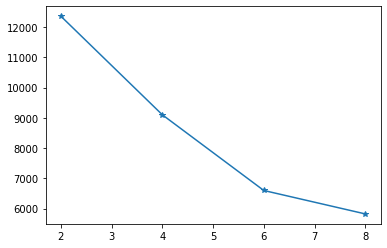

In [213]:
# plot the cost values of clustering vs K values
plt.plot(range(2,10,2), cost_vals, marker='*')
plt.show()

In [214]:
#Calculating Silhouette for K=4 K=6, K=8
X_num = [[row[0], row[4], row[5],row[6]] for row in X] # Variables of X with numeric datatype
X_cat = [[row[1], row[2], row[3]] for row in X] # variables of X with categorical datatype

In [215]:
#Just for reference. 
model = clusters[0] # cluster[0] holds the K-prtotypes model with K=2
silScoreNums = silhouette_score(X_num, model.fit_predict(X,categorical=[1,2,3]), metric='euclidean')
silScoreCats = silhouette_score(X_cat, model.fit_predict(X,categorical=[1,2,3]), metric='hamming')
silScore = (silScoreNums + silScoreCats) / 2
print("The avg Silhouette score for k=2: " + str(silScore))

model = clusters[1] # cluster[1] holds the K-prtotypes model with K=4

# Calculate the Silhouette Score for the numeric and categorical variables seperately
silScoreNums = silhouette_score(X_num, model.fit_predict(X,categorical=[1,2,3]), metric='euclidean')
#print("Silscore for numeric variables: " + str(silScoreNums))
silScoreCats = silhouette_score(X_cat, model.fit_predict(X,categorical=[1,2,3]), metric='hamming') # note the metric here defined to `hamming`
#print("Silscore for categorical variables: " + str(silScoreCats))

# Average the silhouette scores
silScore = (silScoreNums + silScoreCats) / 2
print("The avg silhouette score for k=4: " + str(silScore))

#K=6
model = clusters[2]
silScoreNums = silhouette_score(X_num, model.fit_predict(X,categorical=[1,2,3]), metric='euclidean')
silScoreCats = silhouette_score(X_cat, model.fit_predict(X,categorical=[1,2,3]), metric='hamming')
silScore = (silScoreNums + silScoreCats) / 2
print("The avg Silhouette score for k=6: " + str(silScore))

#K=8
model = clusters[3]
silScoreNums = silhouette_score(X_num, model.fit_predict(X,categorical=[1,2,3]), metric='euclidean')
silScoreCats = silhouette_score(X_cat, model.fit_predict(X,categorical=[1,2,3]), metric='hamming') 
silScore = (silScoreNums + silScoreCats) / 2
print("The avg Silhouette score for k=8: " + str(silScore))

The avg Silhouette score for k=2: 0.3838963473451904
The avg silhouette score for k=4: 0.28258732355282146
The avg Silhouette score for k=6: 0.16989898081970933
The avg Silhouette score for k=8: 0.07371401139788428


## Cluster Visualsation

Cluster membership
0    3227
1     163
Name: Cluster_ID, dtype: int64


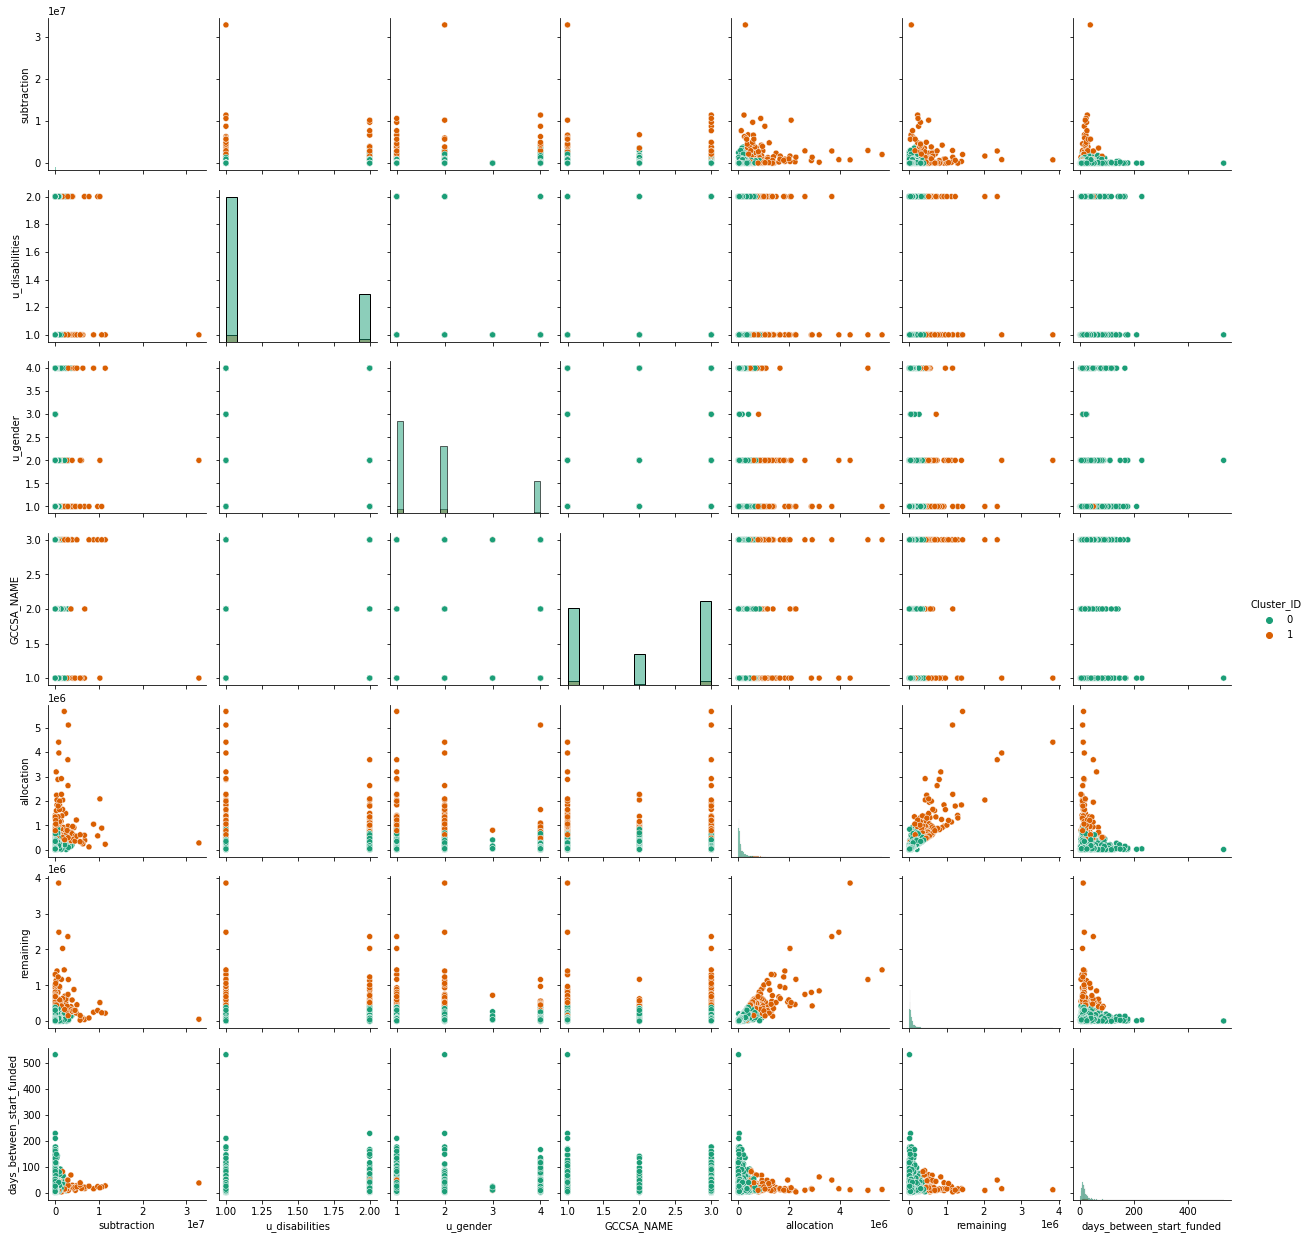

In [216]:
#Choosing K=2 from above and plotting pairplot. Can be modified (K=4/6/8) as needed.
model = clusters[0] #cluster[0] is for K=2
y=model.fit_predict(X, categorical=[1,2,3]) 
final_df1['Cluster_ID'] = y
sns.color_palette("vlag", as_cmap=True)
# how many records are in each cluster
print("Cluster membership")
print(final_df1['Cluster_ID'].value_counts())
# pairplot the cluster distribution.
cluster_g = sns.pairplot(final_df1, hue='Cluster_ID',diag_kind='hist',palette='Dark2')
plt.show()

Cluster membership
0    2893
2     367
1     105
3      25
Name: Cluster_ID, dtype: int64


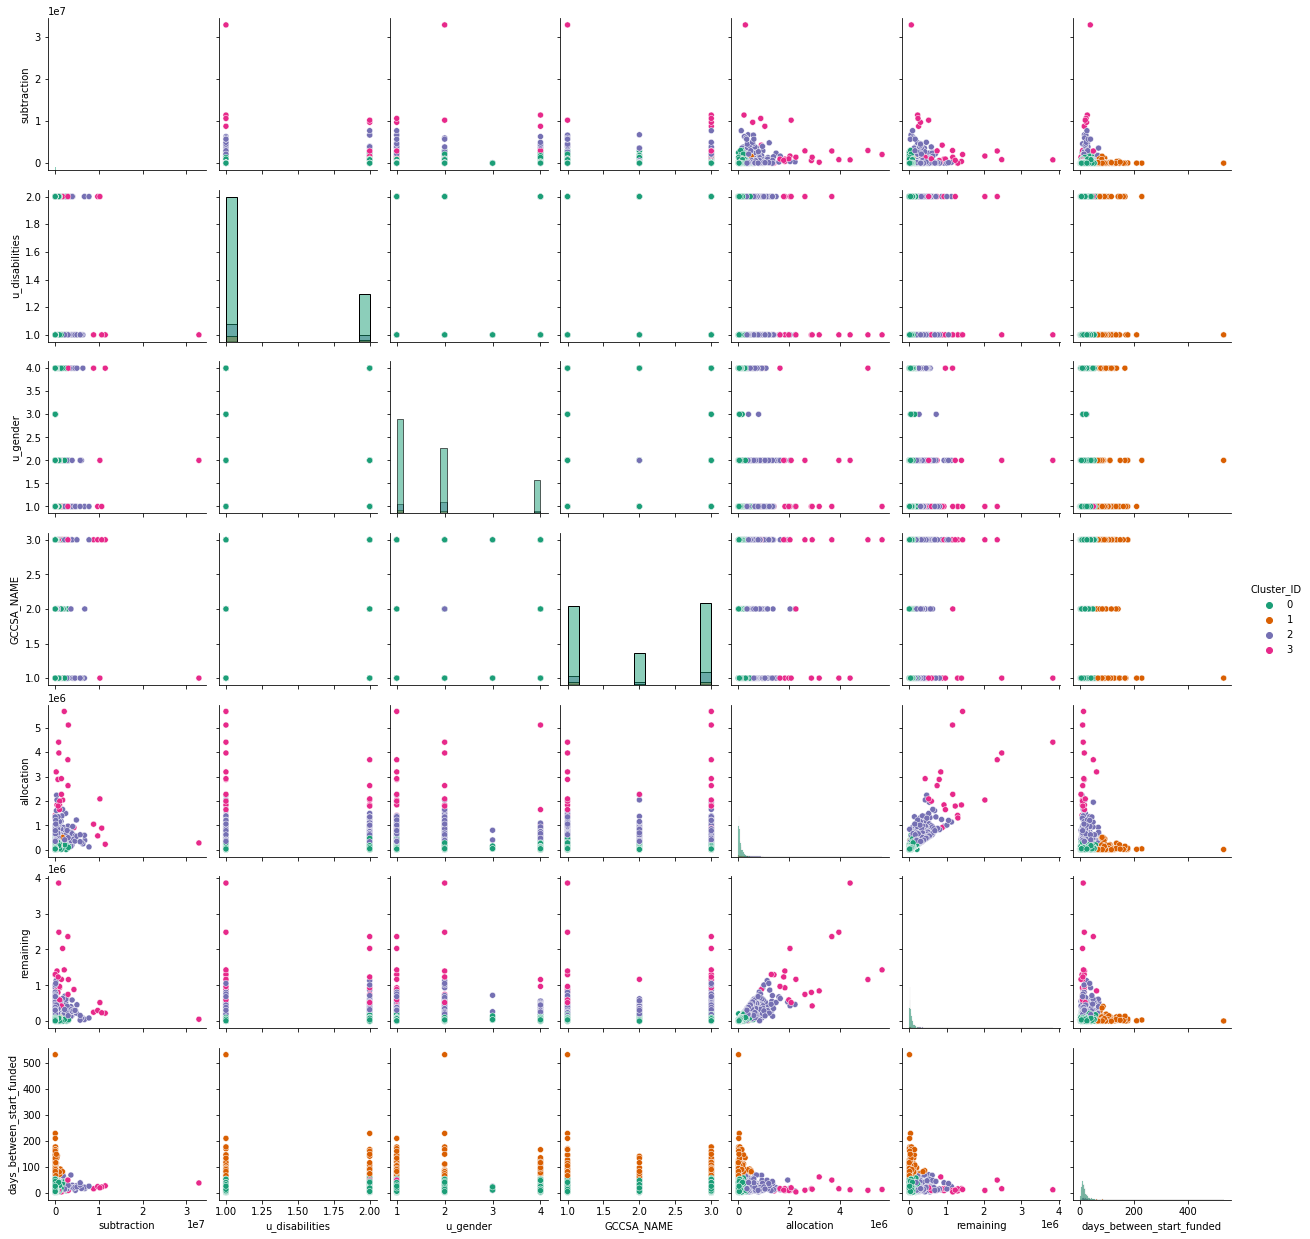

In [217]:
#Choosing K=4 from above and plotting pairplot. Can be modified (K=4/6/8) as needed.
model = clusters[1] 
y=model.fit_predict(X, categorical=[1,2,3]) 
final_df1['Cluster_ID'] = y
sns.color_palette("vlag", as_cmap=True)
# how many records are in each cluster
print("Cluster membership")
print(final_df1['Cluster_ID'].value_counts())
# pairplot the cluster distribution.
cluster_g = sns.pairplot(final_df1, hue='Cluster_ID',diag_kind='hist',palette='Dark2')
plt.show()

Distribution for cluster 0


C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

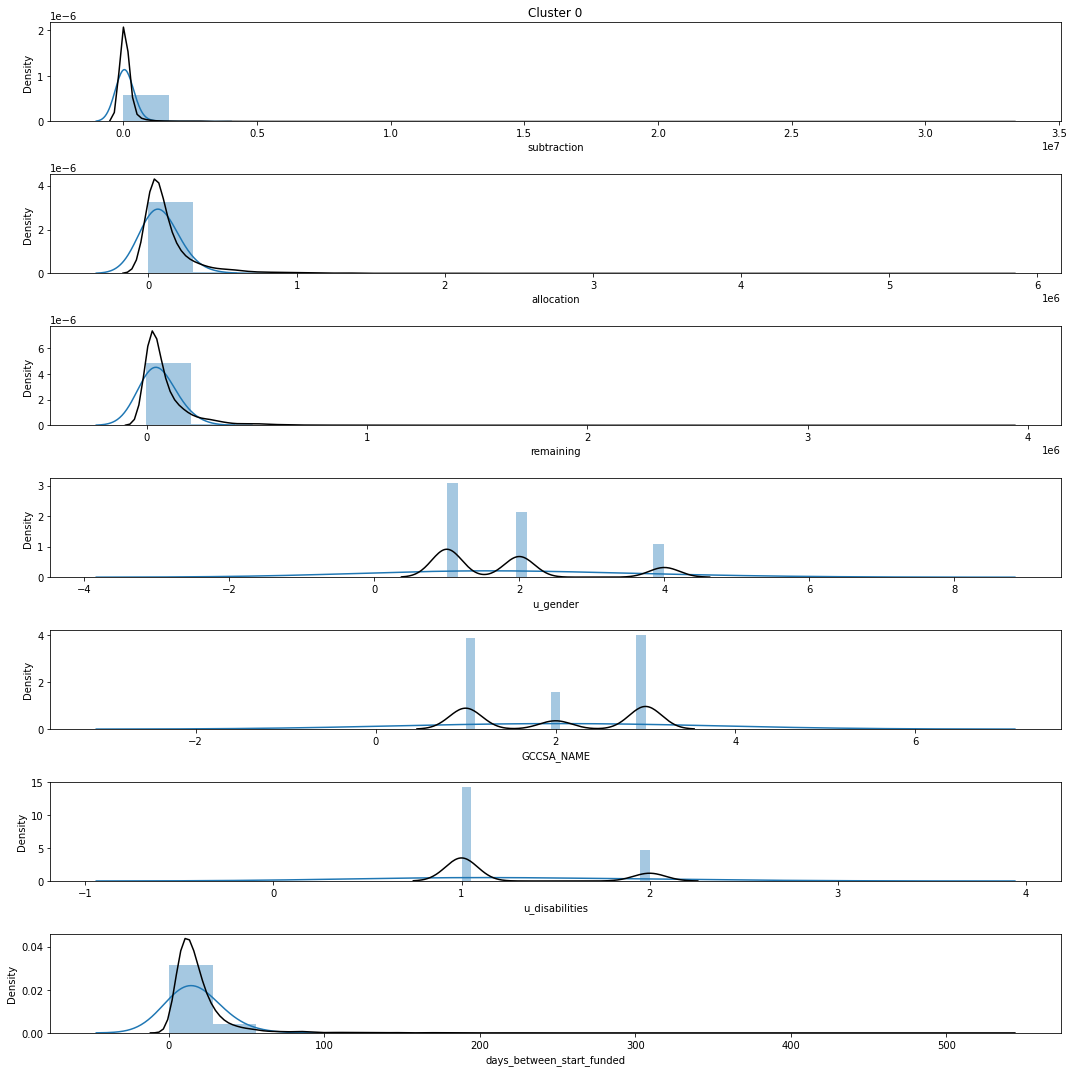

Distribution for cluster 1


C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

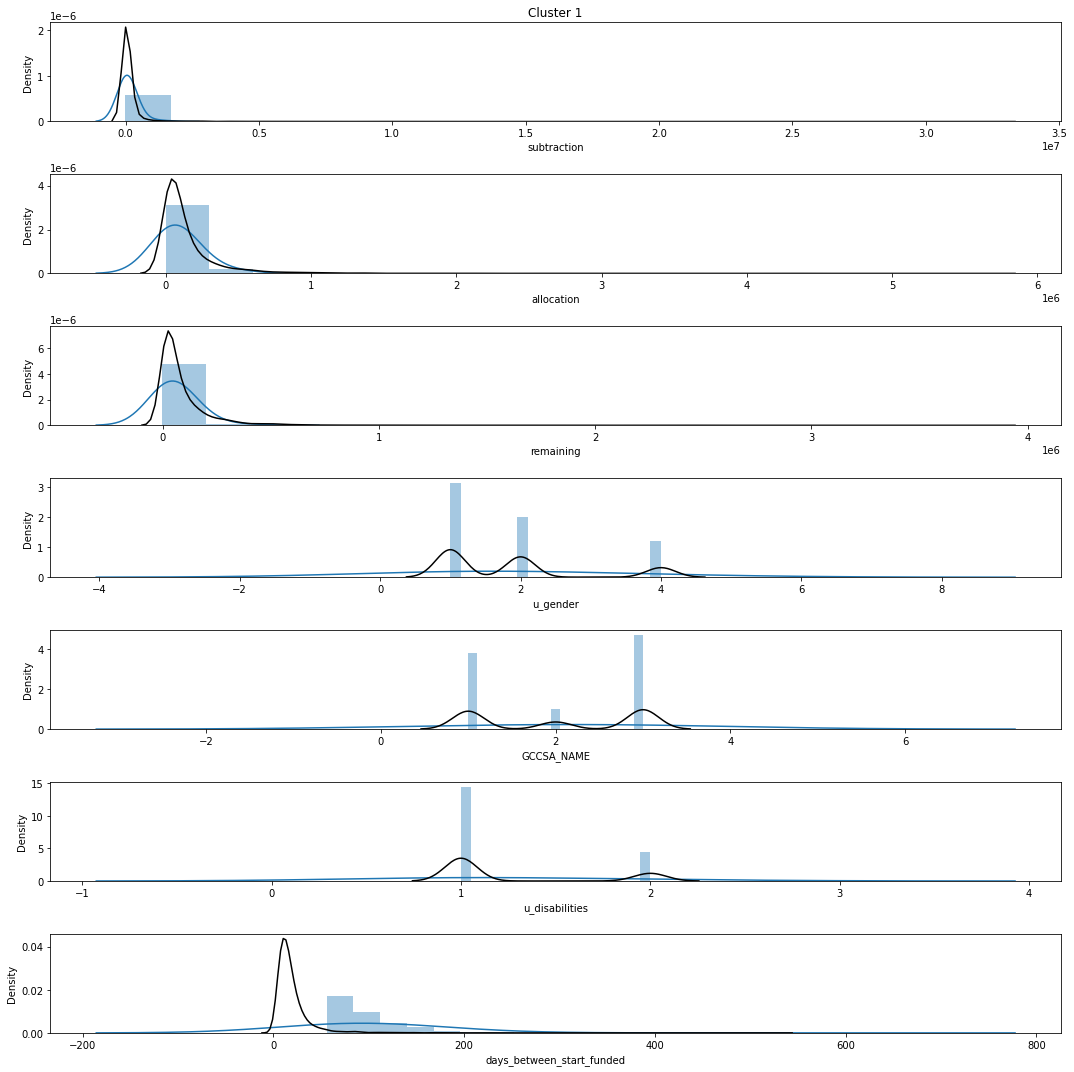

Distribution for cluster 2


C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

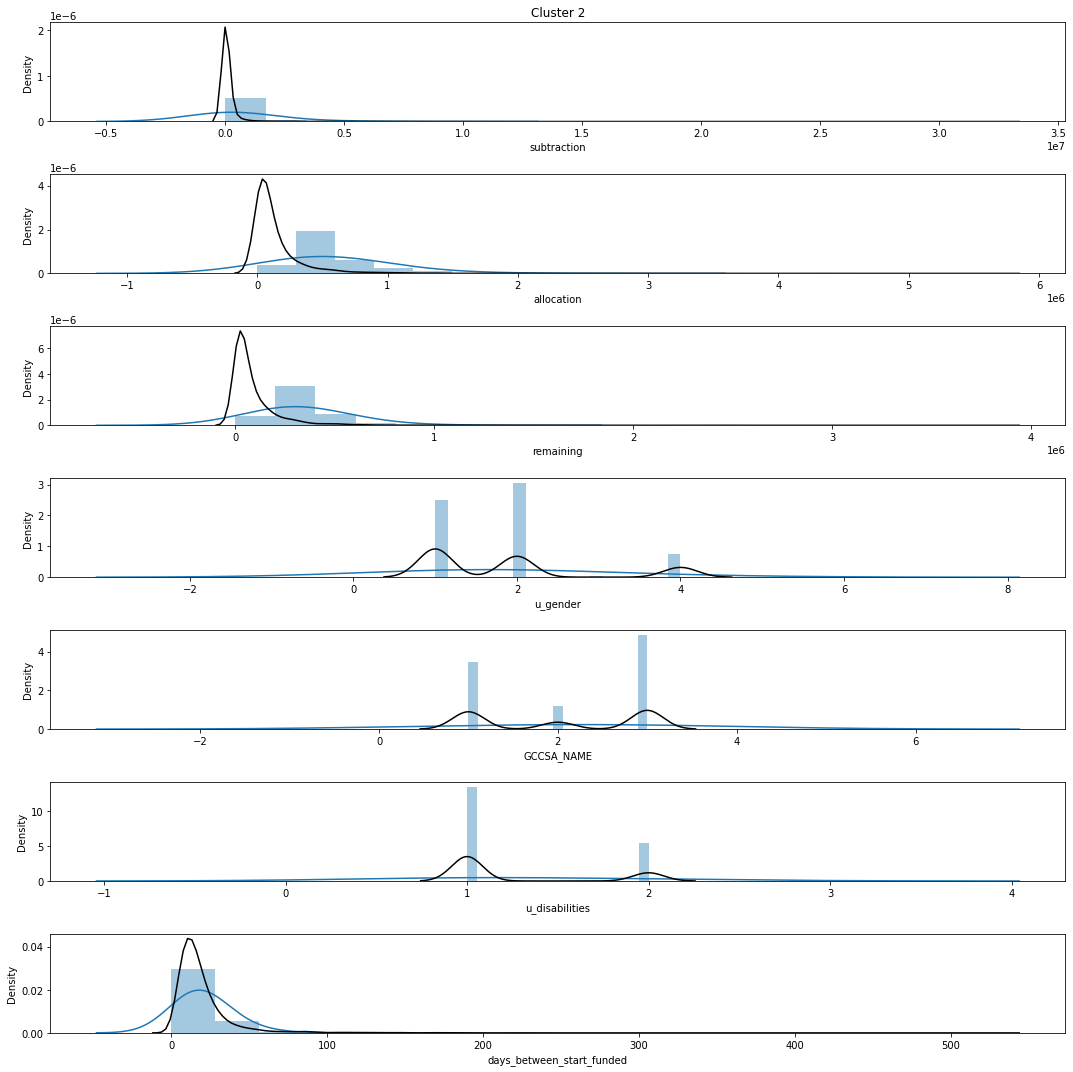

Distribution for cluster 3


C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\ihand\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

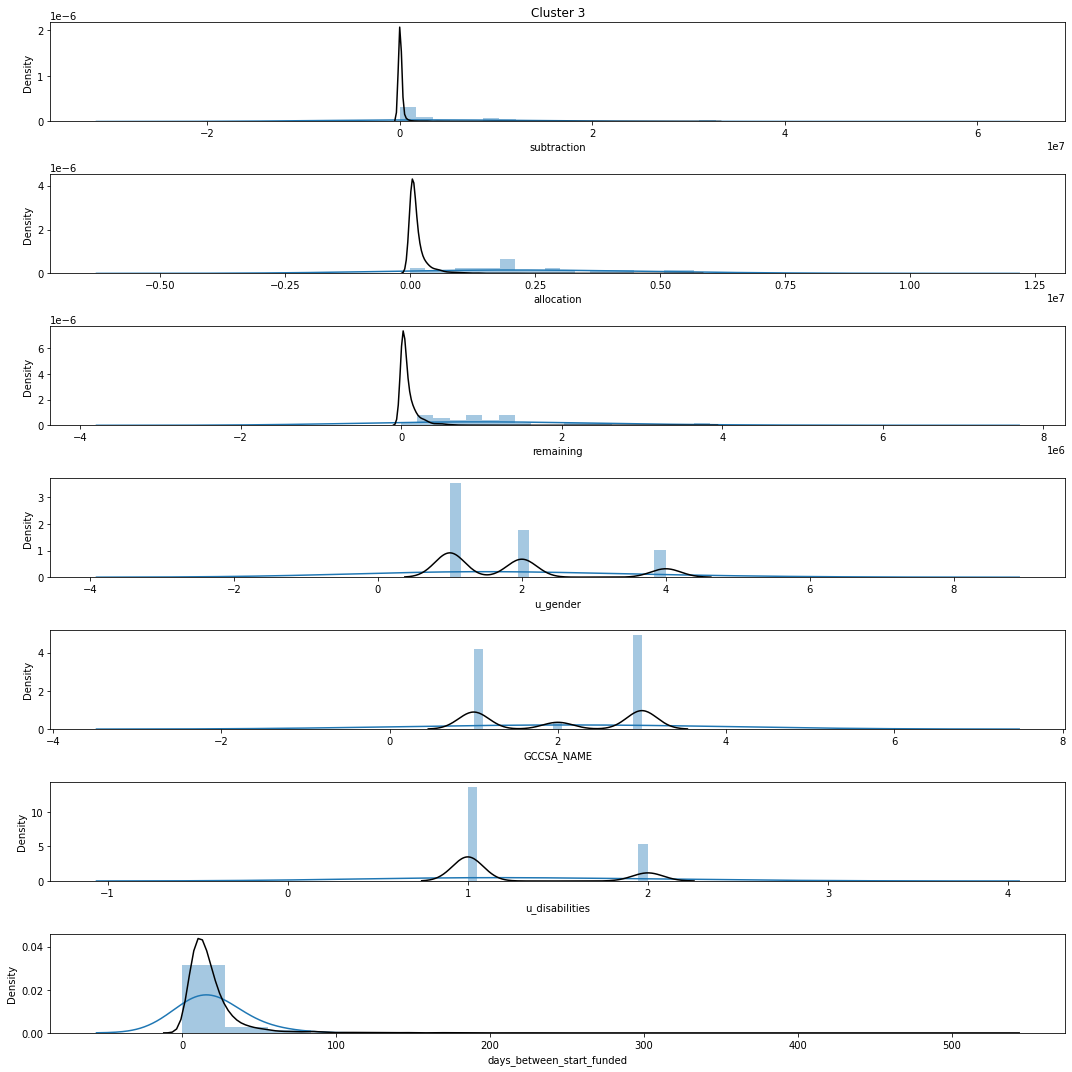

In [218]:
# Distribution for each cluster
cols = ['subtraction', 'allocation', 'remaining', 'u_gender', 'GCCSA_NAME', 'u_disabilities', 'days_between_start_funded']
n_bins = 20

clusters_to_inspect = [0,1,2,3]

for cluster in clusters_to_inspect:
    print("Distribution for cluster {}".format(cluster))
    fig, ax = plt.subplots(nrows=7, figsize=(15,15))
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        bins = np.linspace(min(final_df1[col]), max(final_df1[col]), 20)
        sns.distplot(final_df1[final_df1['Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True, kde_kws={'bw':1.5})
        sns.distplot(final_df1[col], bins=bins, ax=ax[j], hist=False, color="k")
        
    plt.subplots_adjust(bottom=0.1, right=1.8, top=4.5, wspace=0.8, hspace=0.8)
    plt.tight_layout()
    plt.show()

# Model - Association Mining

In [223]:
### All Claim details
df_all_claims = pd.read_sql("select c.id as claim_id, invoice_id as invoiceId, c.item_category_level3_id from HH_claim c", con=conn)

df_all_ndis_service_cat = pd.read_sql("select item_category_level3_id, ndis.registration_group from hedgehog_ndis_service_item_ref ndis", con=conn)

# Combine df_all_claims and df_all_ndis_service_cat
df_claimsWithProvider_details = pd.merge(df_all_claims, df_all_ndis_service_cat, on="item_category_level3_id", how= 'inner')
df_claimsWithProvider_details= df_claimsWithProvider_details.drop(columns=['item_category_level3_id'])

# Provider Services details (Provider account linked to invoice and HH_provider) took 1 minute to execute
df_providersWithInvoice_details = pd.read_sql("select i.id as invoiceId, i.member_id from HH_invoice i;", con=conn)

# Combine df_claim_providers_details and df_providersWithInvoice_details
df_claims_provider_details= pd.merge(df_claimsWithProvider_details, df_providersWithInvoice_details, on="invoiceId", how="left")

In [224]:
# Final claim and Provider df
print(df_claims_provider_details.info())
print(df_claims_provider_details)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969779 entries, 0 to 969778
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   claim_id            969779 non-null  int64 
 1   invoiceId           969779 non-null  int64 
 2   registration_group  969779 non-null  object
 3   member_id           969779 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 37.0+ MB
None
        claim_id  invoiceId                               registration_group  \
0              1          1                             Therapeutic Supports   
1              2          2                             Therapeutic Supports   
2              3          3                             Therapeutic Supports   
3              4          4                             Therapeutic Supports   
4              5          5                             Therapeutic Supports   
...          ...        ...                                 

In [225]:
df_u = pd.read_sql("select id as member_id, membership_number from HH_member m;", con=conn)
df_u.info()
df_u

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6573 entries, 0 to 6572
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   member_id          6573 non-null   int64 
 1   membership_number  6573 non-null   object
dtypes: int64(1), object(1)
memory usage: 102.8+ KB


,member_id,membership_number
0,2,277486509
1,3,815939440
2,4,305008838
3,5,382957405
4,6,549220552
...,...,...
6568,6708,431592727
6569,6709,431543285
6570,6710,431310175
6571,6711,430629242


In [226]:
# Merge 
final_df_a = pd.merge(df_claims_provider_details, df_u, on= "member_id", how="left")
final_df_a= final_df_a.drop(columns=['claim_id', 'invoiceId', 'member_id'])
final_df_a.info()
final_df_a

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969779 entries, 0 to 969778
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   registration_group  969779 non-null  object
 1   membership_number   969779 non-null  object
dtypes: object(2)
memory usage: 22.2+ MB


,registration_group,membership_number
0,Therapeutic Supports,277486509
1,Therapeutic Supports,277486509
2,Therapeutic Supports,815939440
3,Therapeutic Supports,815939440
4,Therapeutic Supports,815939440
...,...,...
969774,Specialised Supported Employment,959385147
969775,Assistive Products For Personal Care And Safety,421664654
969776,Assistive Products For Personal Care And Safety,928510903
969777,Group And Centre Based Activities,354839969


## Data Preparation for the Apriori Algorithm

In [229]:

# group by member num, then list all registration group
services = final_df_a.groupby(['membership_number'])['registration_group'].apply(list)

## Apriori Algorithm

In [230]:
# Type cast the services from pandas into normal list format and run apriori
services_list = list(services)
results = list(apriori(services_list, min_support=0.05))

# print the first 5 rules
print(results[:5])

[RelationRecord(items=frozenset({'Assistance In Coordinating Or Managing Life Stages'}), support=0.20264101728073036, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Assistance In Coordinating Or Managing Life Stages'}), confidence=0.20264101728073036, lift=1.0)]), RelationRecord(items=frozenset({'Assistance With Daily Life Tasks In A Group Or Sha'}), support=0.1284642973589827, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Assistance With Daily Life Tasks In A Group Or Sha'}), confidence=0.1284642973589827, lift=1.0)]), RelationRecord(items=frozenset({'Assistance With Travel/Transport Arrangements'}), support=0.0626018910987936, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Assistance With Travel/Transport Arrangements'}), confidence=0.0626018910987936, lift=1.0)]), RelationRecord(items=frozenset({'Assistive Products For Personal Care And Safety'}), support=0.5329312031300946, 

### For future reference, you can make the following changes as needed in the above code by considering:

### (1) If you are interested in generating associations that involve fairly rare services, you should consider reducing min_support. 

### (2) If the items present in the dataset do not show high support, 'min_support' threshold should be set to small value and vice-versa.
 
### (3) If you obtain too many rules to be practically useful, you should consider increasing min_suport and min_confidence.

## Association Rules

In [231]:
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 
                                        'Confidence', 'Lift']) 

result_df = convert_apriori_results_to_pandas_df(results)

print(result_df.head(20))

                                            Left_side  \
0                                                       
1                                                       
2                                                       
3                                                       
4                                                       
5                                                       
6                                                       
7                                                       
8                                                       
9                                                       
10                                                      
11                                                      
12                                                      
13                                                      
14                                                      
15                                                      
16                             

## Organised Association rules by the lift values

In [232]:
result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(20))

                                              Left_side  \
2775  Daily Personal Activities (Assist Personal Act...   
2770  Participation In Community, Social And Civic A...   
2763  Daily Personal Activities (Assist Personal Act...   
2782  Participation In Community, Social And Civic A...   
2768  Daily Personal Activities (Assist Personal Act...   
2777  Participation In Community, Social And Civic A...   
1217  Participation In Community, Social And Civic A...   
1212  Daily Personal Activities (Assist Personal Act...   
2764  Participation In Community, Social And Civic A...   
2781  Daily Personal Activities (Assist Personal Act...   
4356  Daily Personal Activities (Assist Personal Act...   
4331  Participation In Community, Social And Civic A...   
4334  Daily Personal Activities (Assist Personal Act...   
4353  Participation In Community, Social And Civic A...   
4338  Participation In Community, Social And Civic A...   
4349  Daily Personal Activities (Assist Personal Act... 

# Model - Neural Network


## Drop columns with unique values.


In [219]:
df = df.drop(columns=['spending_ratio',"plan_key", "member_key","start_date", "end_date", 'subtraction', 'allocation', 'remaining', 'spent'])

In [220]:
# Summary information for df
df.info()
df.head(100)

<class 'pandas.core.frame.DataFrame'>
Index: 3404 entries, 100348708 to 999694603
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   under_spent         3404 non-null   bool 
 1   over_spent          3404 non-null   bool 
 2   par_spent           3404 non-null   bool 
 3   gender_Female       3404 non-null   bool 
 4   gender_Male         3404 non-null   bool 
 5   gender_Other        3404 non-null   bool 
 6   gender_Unknown      3404 non-null   bool 
 7   GCCSA_Rural         3404 non-null   bool 
 8   GCCSA_Unknown       3404 non-null   bool 
 9   GCCSA_Urban         3404 non-null   bool 
 10  not_fully_funded    3404 non-null   bool 
 11  acceptable_funded   3404 non-null   bool 
 12  u_dis_Intellectual  3404 non-null   uint8
 13  u_dis_others        3404 non-null   uint8
dtypes: bool(12), uint8(2)
memory usage: 73.1+ KB


,under_spent,over_spent,par_spent,gender_Female,gender_Male,gender_Other,gender_Unknown,GCCSA_Rural,GCCSA_Unknown,GCCSA_Urban,not_fully_funded,acceptable_funded,u_dis_Intellectual,u_dis_others
membership_number,,,,,,,,,,,,,,
100348708,True,False,False,True,False,False,False,False,True,False,True,False,0,1
100969245,True,False,False,True,False,False,False,False,False,True,True,False,0,1
101279515,True,False,False,True,False,False,False,False,True,False,True,False,0,1
101391416,True,False,False,True,False,False,False,True,False,False,True,False,1,0
101528743,True,False,False,False,False,False,True,False,True,False,True,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12344398,True,False,False,True,False,False,False,True,False,False,True,False,1,0
123476419,True,False,False,True,False,False,False,False,True,False,True,False,0,1
123786685,True,False,False,True,False,False,False,False,False,True,True,False,0,1


## Code for generating the Neural Network Model.

### *Uncomment this code if you wish to train the model again or if there are any changes in the dataset.*

In [221]:
'''
# Specify the target column for analysis
target_column = "under_spent"
# Create the input df
input_df = df.drop([target_column], axis=1)
# Create a target df
target_df = df[target_column]
# Set random state
random_state = 10
# Set test size
test_size = 0.3
# Nump-ify input_df2
input_df_mat = input_df.to_numpy()
# Split training and test data
input_df_train, input_df_test, target_df_train, target_df_test = train_test_split(input_df_mat, target_df, test_size=test_size, stratify=target_df, random_state=random_state)
# Get standard scaler
scaler = StandardScaler()
# Transform training and test data
input_df_train = scaler.fit_transform(input_df_train, target_df_train)
input_df_test = scaler.transform(input_df_test)
# Generate a prediction
model_1 = MLPClassifier(random_state=random_state)
model_1.fit(input_df_train, target_df_train)
target_prediction = model_1.predict(input_df_test)
'''


'\n# Specify the target column for analysis\ntarget_column = "under_spent"\n# Create the input df\ninput_df = df.drop([target_column], axis=1)\n# Create a target df\ntarget_df = df[target_column]\n# Set random state\nrandom_state = 10\n# Set test size\ntest_size = 0.3\n# Nump-ify input_df2\ninput_df_mat = input_df.to_numpy()\n# Split training and test data\ninput_df_train, input_df_test, target_df_train, target_df_test = train_test_split(input_df_mat, target_df, test_size=test_size, stratify=target_df, random_state=random_state)\n# Get standard scaler\nscaler = StandardScaler()\n# Transform training and test data\ninput_df_train = scaler.fit_transform(input_df_train, target_df_train)\ninput_df_test = scaler.transform(input_df_test)\n# Generate a prediction\nmodel_1 = MLPClassifier(random_state=random_state)\nmodel_1.fit(input_df_train, target_df_train)\ntarget_prediction = model_1.predict(input_df_test)\n'

In [222]:
# Summary Information of the model.
print("Classification Report: \n", classification_report(target_df_test, target_prediction))
print("Train Accuracy: ", model_1.score(input_df_train, target_df_train))
print("Test Accuracy: ", model_1.score(input_df_test, target_df_test))
print("Default Model Characteristics: ", model_1)

NameError: name 'target_df_test' is not defined

## OPTIONAL - Neural Network tuned with GridSearchCV

### *Uncomment this code if you wish to train the model again or if there are any changes in the dataset.*

In [ ]:
'''
hiddenLayerSizes = [(2,), (3, ), (4, ), (5, ), (6, ), (7, )]

alpha = [0.01, 0.001, 0.0001, 0.00001]

params = {'hidden_layer_sizes': hiddenLayerSizes, 'alpha': alpha}

model_2 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=random_state), cv=10, n_jobs=-1)

model_2.fit(input_df_train, target_df_train)

target_prediction = model_2.predict(input_df_test)

'''

In [ ]:
# Summary Information of the model.
print("Classification Report: \n", classification_report(target_df_test, target_prediction))
print("Train Accuracy: ", model_2.score(input_df_train, target_df_train))
print("Test Accuracy: ", model_2.score(input_df_test, target_df_test))
print("Tuned Model Characteristics: ", model_2)
print("Best Parameters: \n", model_2.best_params_)

## Export the Neural Network Model as a *.sav* file

In [ ]:
import pickle
filename = './FinalisedModels/nn_model.sav'
pickle.dump(model_1, open(filename, 'wb'))

## Tests for .sav file

In [ ]:
# Load the model from disk.
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(input_df_test, target_df_test)
print(result)

In [ ]:
'''
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[33,2,0,0,0,0,0,0,0,1,3], 
        [3,31,0,0,0,0,0,0,0,0,0], 
        [0,4,41,0,0,0,0,0,0,0,1], 
        [0,1,0,30,0,6,0,0,0,0,1], 
        [0,0,0,0,38,10,0,0,0,0,0], 
        [0,0,0,3,1,39,0,0,0,0,4], 
        [0,2,2,0,4,1,31,0,0,0,2],
        [0,1,0,0,0,0,0,36,0,2,0], 
        [0,0,0,0,0,0,1,5,37,5,1], 
        [3,0,0,0,0,0,0,0,0,39,0], 
        [0,0,0,0,0,0,0,0,0,0,38]]
df_cm = pd.DataFrame(array, index = [i for i in "ABCDEFGHIJK"], columns = [i for i in "ABCDEFGHIJK"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

'''